# Projet d'optimisation : chauffage d'un bâtiment résidentiel
#### *Sebastian Partarrieu & Clement Desroches*

# I - Modélisation


### Question 1

En premier lieu, on cherche à effectuer un modèle plausible compte tenu des données fournies.
Pour ce modèle, nous allons faire directement plusieurs hypothèses préliminaires: 
- le chauffage est exclusivement électrique, c'est justifié ces dernières années. 
- on suppose que l'énergie utilisée par la maison est exclusivement dûe au chauffage (c'est ce qu'on cherche à minimiser). Rajouter des sources de consommation d'énergies externes ne nous intéresse pas ici.

Ainsi la fonction à minimiser reste la facture d'électricité qui est uniquement reliée au chauffage pûrement effectué de manière électrique. On note $E_p$ ($E_c$) l'énergie consommée par la maison en heure pleine (creuse), $t_p$ ($t_c$) le tarif en heures pleines (creuses). On note M le montant à payer pour la consommation d'électricité.

Alors:
<center> $M = E_c * t_c + E_p * t_p \tag{1}$ </center>  

est la quantité que l'on sera amené à minimiser dans la deuxième partie de ce projet. Sa forme plus explicite ainsi que les contraintes associées seront détaillées une fois le modèle dynamique établi qui révelera les puissances mises en jeu à intégrer pour remonter aux énergies consommées.

### Question 2

Nous allons essayer de proposer un modèle de la température intérieure de la maison. Nous prenons donc comme système thermodynamique cet air à l'intérieur de la maison qui déterminera le confort des personnes à l'intérieur (en négligeant le fait que le confort thermique dépend de plusieurs facteurs, qui ne sont pas $T_{amb}$ la température ambiante de l'air, dont le métabolisme, les vêtements portés, l'humidité relative de l'air, la température des parois ou même la vitesse des mouvements d'air à l'intérieur de la maison).

In [14]:
#Petite illustration des ordres de grandeur associés aux différentes sources de pertes thermiques
from IPython.display import Image
Image(url = 'https://www.mrcentralheating.co.uk/media/wysiwyg/houseHeat4.jpg', width = 300)

>Venons en donc aux différentes sources de transferts thermiques considérées ici qui sont :
>- le **chauffage intérieur** qui fournit une puissance $p_c(t)$
>- les **transferts thermiques à travers les murs** que l'on caractérise par un coefficient de perte $a$ qui sera déterminé par la suite.
>    Si l'on suppose que la maison est un cube de coté l, et les murs sont d'épaisseur $e_{mur}$ et le plafond $e_p$.
>    Pour un mur on obtient (On néglige la convection à l'intérieur de la maison) $R_{eq/mur} = \frac{1}{h*S_{mur}} + \frac{e_{mur}}{\lambda_{mur} * S_{mur}}$ avec $h$ le coefficient conducto-convectif qui caractérise les échanges de chaleur entre la paroi externe du mur et l'air.
>   
>    Donc pour 4 murs (en parallèle) : $ R_{eq/ 4murs} = \frac{R_{eq/mur}}{4}$    
>    
>    Pour le plafond : $R_{eq/p} = \frac{1}{h*S_{p}} + \frac{e_{p}}{\lambda_p * S_{p}}$ en considérant le même coefficient d'échange conducto-convectif que pour les murs (une hypothèse justifiée ci-dessous).
>    
 >   Donc pour la maison en entier : $R_{eq/ maison} = (\frac{1}{R_{eq/p}} + \frac{1}{R_{eq/4murs}})^{-1}$
 >   
 >   Alors on obtient finalement le coefficient de perte global de la maison qui caractérise les flux de chaleur à travers les parois: <center>$a = \frac{1}{R_{eq/maison}}, \Phi_{parois} = a*(T_{ext}(t)-T_{int}(t)) \tag{2}$</center>
 >   
>- **rayonnement thermique** : 
 >   $I_s(t) * S_{maison} * b$ (b étant un coefficient d'atténuation moyenné sur les quatres murs et le toit, $S_{maison}$ la surface extérieure de la maison et $I_s(t)$ le flux solaire moyenné sur les quatres murs et le toit) qui dépend de l'heure de la journée et donc du temps. 
    
Les hypothèses effectuées sont donc:
- La maison est cubique
- On néglige les mouvements d'air à l'intérieur de la maison.
- On considère un même coefficient conducto-convectif entre les murs et l'air et le plafond et l'air. Concrètement, comme la nature du fluide et la température est la même dans les deux cas, ceci revient à considérer qu'il y a le même type d'écoulement au dessus du plafond et au niveau des parois. 
- On néglige l'apport interne dû aux occupants, on considère donc une maison vide.
- On néglige la ventilation et les infiltrations d'air dans le bâtiment.
- On néglige les pertes par le sol, on fait l'hypothèse que le plancher est bien isolé et que la température du sol est proche de la température intérieure.
- Pour le rayonnement incident, en réalité il n'y que la surface *vitrée* sud qui laisse passer le rayonnement à l'intérieur, mais ici on fait une moyenne sur l'ensemble de la maison en considérant des parois semi-opaques caractérisées par ce coefficient d'atténuation
- En réalité, on a le flux solaire frappant une paroi qui se décompose en trois termes: le flux direct qui dépend de l'inclinaison et l'orientation des parois, le flux diffus (nuages), et le flux réfléchi par le sol et les autres parois. Ici on ne considère que le flux direct n'ayant pas accès aux conditions météo et ne pouvant pas décomposer le flux incident en cette somme de termes plus précis.

Finalement l'équation qui régit la dynamique de température de l'air à l'intérieur de la maison est: 
       <center> $\boxed{C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + p_c(t) + I_s(t) * S * b} \tag{3} $ </center>
       où $C_{air}$ est la capacité thermique de l'air à l'intérieur de la maison.

### Question 3

#### Visualisation des données

Avant de discrétiser la dynamique et de proposer une méthodologie d'identification, on représente les données fournies pour appréhender correctement le problème. 

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
import pandas as pd

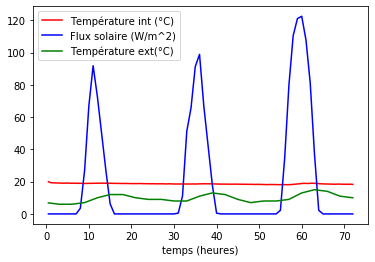

In [62]:
#visualisation des données
df = pd.read_csv('donnees-projet-gr4.txt', header = None,  delimiter='\t')
T, Y1, Y2, Y3 = np.array(df[0]), np.array(df[1]), np.array(df[2]), np.array(df[3])
plt.xlabel('temps (heures)')
plt.plot(T, Y1, c='r', label = 'Température int (°C)')
plt.plot(T, Y2, c='b', label = 'Flux solaire (W/m^2)')
plt.plot(T, Y3, c='g', label = 'Température ext(°C)')
plt.legend(loc='upper left')
plt.show()

On observe donc l'évolution de certains paramètres du problème sur une durée de trois jours. Les grandeurs physiques sont échantillonées toutes les demi-heures. On voit directement que la température à l'intérieur de la maison reste presque constante au cours du temps, **sans chauffage a priori** ce qui nous amènera à éliminer le terme $p_c(t)$ dans l'équation (3). On sera amené à considérer des températures extérieures différentes ainsi que des autres niveaux de confort demandé à l'intérieur (température intérieure) plus tard dans le sujet.  


Pour l'instant, **reprenons l'équation décrite précedemment** sans terme de chauffage, 

$$C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + I_s(t) * S_{maison} * b \tag{4}$$

On a $C_{air} = c_{air}V_{maison}$ avec $c_{air} = 1,256  kJ.m^{-3}.K^{-1}$ la capacité thermique volumique de l'air. D'après le modèle précédent, on a $V_{maison} = l^3$ avec $l$ le côté du carré qui modélise les murs et le plafond de la maison.

On connaît l'évolution de $T_{int}(t)$, $T_{ext}(t)$ et $I_s(t)$. Il s'agit donc d'identifier les paramètres $S_{maison} = 5*l^2$, $a$, $b$ et $V_{maison} = l^3$. Finalement, il s'agit d'identifier $l$, $a$ et $b$, suivant la méthode décrite prochainement. 

On note simplement à ce stade qu'on peut mettre (4) sous la forme d'une équation différentielle du premier ordre sur $T_{int}$ avec des coefficients constants mais un second membre non constant. La solution explicite de l'équation homogène associée est directe, sous la forme: $$T_{int}^{H}(t) = e^{-\frac{a}{C_{air}}*t}$$
La solution particulière se trouve avec la méthode de "variation de la constante", cependant ce n'est pas intéressant de faire la résolution analytique ici. On préférera implémenter directement une résolution numérique de l'équation différentielle:
$$y' = f(t,y,a,b,l) \tag{5}$$ 

#### Identification des constantes et discrétisation de la dynamique

*Explication de la démarche*: Prenons l'équation (5), on va trouver avec l'aide d'un bon vieux Euler codé à la main, la fonction $T_{int}$ solution de l'équation. Implémenter un Runge-Kutta ou un solveur ODE dédié est plus difficile car on a pas accès aux fonctions continues qu'on pourrait évaluer en n'importe quel point mais à des données déjà discrétisées.

On aura donc N = 144 points de température avant de procéder à une pénalisation des moindres carrés et un algorithme des moindres carrés non linéaire, qui est donc soit Gauss-Newton ou Levenberg-Marquardt. Ici on pourra utiliser des algorithmes de scipy.optimize comme curve_fit ou least_squares pour implémenter ces algorithmes. 

Procédons ainsi à la résolution numérique de l'équation différentielle (5) en dicrétisant le tout et en approximant l'intégrale avec la méthode des rectangles à gauche.
Cela donne : $$C_{air}*(T_{int}^{i+1}) = \Delta t * a *T_{ext}^{i}+T_{int}^{i}(C_{air} - \Delta t * a) + I_s^{i} * S_{maison} * b*\Delta t$$

et finalement, en remplacant a par a' (on note a' par a dans le code par simplicité) une résistance surfacique (de sorte à éliminer la dépendance entre a et l qui amène à des résultats abhérents en tournant nos algorithmes d'optimisation), telle que $a' = \frac{a}{5 l^2}$

In [124]:
def myfunc(Tint, i, a, b, l):
    '''
    Renvoie l'itération suivante, le T_{int}^{i+1},pour une méthode d'Euler en utilisant un rectangle à gauche pour approximer 
    l'intégrale. Il est plus aisé de donner i l'indice dans la discrétisation que le temps.
    En se rappelant que pour les données extraites, T est le temps, Y1 Tint, Y2 le flux solaire
    et Y3 Text. On rappelle que c_{air}, la capacité thermique volumique de l'air 1256 J.m-3.K-1 et que le pas de temps est 
    fixé par nos donnée et vaut une demi-heure, soit 1800s.
    ON OUBLIE PAS DE METTRE LES TEMPERATURES EN KELVIN
    '''
    pas_temps = 1800.0
    cair = 1256.0
    alpha = (pas_temps*a*5)/(cair*(l))
    return alpha*(Y3[i] + 273.15) + (1 - alpha)*(Tint + 273.15) + (5*b*pas_temps/(cair*l))*Y2[i]

In [125]:
def Euler_explicit(func, a, b, l):
    '''
    Implémente Euler explicite. Vu que la plupart des paramètres sont fixés par notre discrétisation prélable, on a pas besoin
    de préciser le nombre de points ou la condition initiale dans les arguments.
    '''
    y0 = Y1[0] + 273.15
    T_int = [y0]
    for i in range(1, len(Y1)):
        T_int.append(func(T_int[i-1], i-1, a, b, l))
    return np.array(T_int)

In [126]:
def penalisation(X):
    T_int_1 = Euler_explicit(myfunc, X[0], X[1], X[2]) 
    T_int_reel = Y1 + 273.15
    return np.array([np.sum((T_int_1 - T_int_reel)**2) for _ in range(3)]) #Pour avoir un vecteur de taille 3 en sortie

In [127]:
Result = optimize.least_squares(penalisation, np.array([.1, 0.001, 10]), method='lm')
a = Result.x
print(a)

[ 1.03621387 -0.01732959  7.67441949]


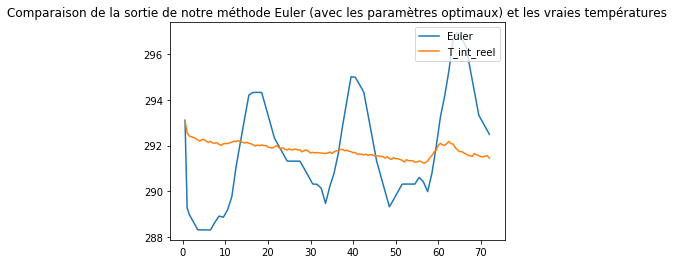

In [128]:
plt.plot(T, Euler_explicit(myfunc, a[0], a[1], a[2]), label="Euler")
plt.plot(T, Y1+273.15, label="T_int_reel")
plt.legend(loc='upper right')
plt.title('Comparaison de la sortie de notre méthode Euler (avec les paramètres optimaux) et les vraies températures')
plt.show()

On remarque tout de même que la fonction finale ne colle pas du tout à nos valeurs réelles. Ceci est dû à l'accumulation de l'erreur en utilisant Euler explicite. Cependant, comme expliqué avant, il est difficile d'implémenter un schéma numérique plus précis car on ne dispose pas des fonctions analytiques mais de fonctions déjà discrétisées. On remarque que les valeurs de a, b et l ne sont pas complètement abhérentes d'un point de vue physique (sauf le signe de b) mais au vu de la courbe produite par ces valeurs on se doute qu'ils ne représentent pas les meilleures estimations possibles.

On procède ainsi à une méthode similaire à celle présentée en annexe, on réinitialise à chaque pas la valeur de $T_{int}$ de sorte à considérer non pas une erreur cumulée mais une erreur locale sur chaque point de la discrétisation. 

In [133]:
def myfunc2(Tint, i, a, b, l):
    '''
    Calcul du pas suivant sans accumulation de l'erreur.
    '''
    pas_temps = 1800.0
    cair = 1256.0
    alpha = (pas_temps*a*5)/(cair*l)
    return alpha*(Y3[i] + 273.15) + (1 - alpha)*(Y1[i] + 273.15) + (b*5*1800/(cair*l))*Y2[i]

def penalisation2(X):
    T_int_1 = Euler_explicit(myfunc2, X[0], X[1], X[2]) 
    T_int_reel = Y1 + 273.15
    return np.array([np.sum((T_int_1 - T_int_reel)**2) for _ in range(3)])

Result2 = optimize.least_squares(penalisation2, np.array([1, .001, 8]), method='lm')
a2 = Result2.x
print(f'a2 = {a2[0]}, b2 = {a2[1]}, l2 = {a2[2]}')

a2 = 0.004929126082514527, b2 = 0.0012303639065839552, l2 = 12.484094197222378


In [134]:
#Paramètres trouvés avec d'autres conditions initiales très différentes
Result3 = optimize.least_squares(penalisation2, np.array([100, .01, 10]), method='lm')
a3 = Result3.x
print(f'a3 = {a3[0]}, b3 = {a3[1]}, l3 = {a3[2]}')

a3 = 0.003487872015211847, b3 = 0.0008705942381449126, l3 = 8.833402224814497


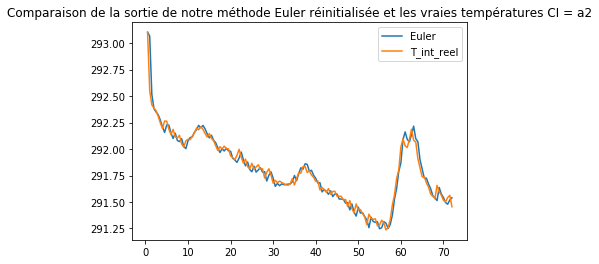

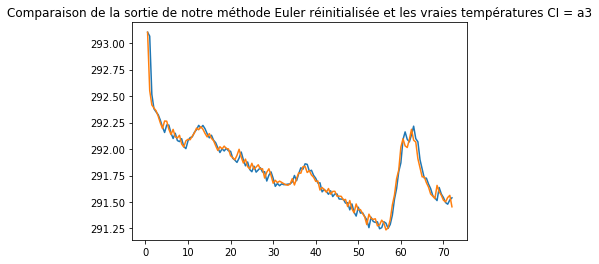

In [135]:
plt.plot(T, Euler_explicit(myfunc2, a2[0], a2[1], a2[2]), label="Euler")
plt.plot(T, Y1+273.15, label="T_int_reel")
plt.legend(loc='upper right')
plt.title('Comparaison de la sortie de notre méthode Euler réinitialisée et les vraies températures CI = a2')
plt.show()
plt.plot(T, Euler_explicit(myfunc2, a3[0], a3[1], a3[2]), label="Euler")
plt.plot(T, Y1+273.15, label="T_int_reel")
plt.title('Comparaison de la sortie de notre méthode Euler réinitialisée et les vraies températures CI = a3')
plt.show()

**Conclusion** On a donc implémenté un "Euler réinitialisé", en fait en considère juste l'erreur locale à chaque pas de la discrétisation et on cherche à minimiser l'écart entre ces erreurs et $T_{int}$ donnée à travers le choix des paramètres a , b et l. On voit que cette méthode aboutit sur des résultats *beaucoup* plus cohérents. Notre maison est de l'ordre de $100 m^2$ ce qui est plutôt cohérent (même si avec 10m de hauteur c'est plutôt un immeuble :) ). Le paramètre a' est de l'ordre de $0,005 W.K^{-1}.m^{-2}$, d'où $a = 2,5 W.K^{-1}$ ce qui se traduit en une résistance thermique $R_{eq/maison} = 0.4 K.W^{-1}$. Finalement le paramètre b est de l'ordre de $0.0010$ ce qui semble très logique vu qu'on a effectué une moyenne d'un coefficient d'atténuation sur l'ensemble de la maison. Cet ordre de grandeur ne fait que traduire qu'il existe une grande surface de parois opaques qui ne laissent rentrer que très peu de lumière.

On note cependant que, si la valeur de l est très stable du point de vue des conditions initiales, les valeurs de a et b sont un peu plus sensibles à celles-ci. Cependant, comme on l'a illustré ci-dessus en prennant des conditions initiales très différentes pour a et b, nos valeurs restent du même ordre de grandeur! De plus, pour les deux conditions initiales notre résolution réinitialisée à chaque pas reste quand même proche de la courbe réelle de Tint.

### Question 4

Nous avons donc déterminé les trois constantes a, b et l. Nous ne pouvons pas contrôler $I_{s}(t)$ ni $T_{ext}(t)$ et il s'agit de contrôler $T_{int}(t)$ à travers la consommation électrique (chauffage).

Le problème d'optimisation est donc maintenant de minimiser la consommation électrique de la maison, liée à la puissance, elle même liée à d'autres paramètres physiques déterminés précédemments:
 <center> $ p_c(t) = C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}}  - I_s(t) * S * b - a*(T_{ext}(t)-T_{int}(t)) \tag{6} $ </center>

D'après EDF les heures creuses sont limitées à 8h maximum par jour, nous choisissons une plage d'heures creuses de 00h00 à 8h du matin.
 
Donc $E_c = \int_{0}^{8h}p_c(t)dt$ et de même $E_p = \int_{8h}^{24h}p_c(t)dt$

Finalement cela nous donne la fonction objective à minimiser qui est une fonction d'un profil de puissance à travers la journée (c'est à dire de $t \rightarrow p_{c}(t)$ pour $t \in [0, 24hr]$ (variable de décision)):

$$f(p_c(t)) = \int_{0}^{8h}p_c(t)dt*t_{c} + \int_{8h}^{24h}p_c(t)dt*t_{p} \tag{7}$$ avec $t_c$ et $t_p$ les tarifs en heures creuses et pleines.

En suivant la même démarche de discrétisation que pour la question 3, la variable de décision est un vecteur de $\Re ^{N}$ où N = 144, le nombre de points de discrétisation, qui contient les $p_i$ puissance instantanée en $t_i$. Ainsi notre fonction objective n'est plus (7) mais est donc (comme on prend 8 heures et que les données commencent à minuit):
$$X = \begin{pmatrix}{p_1\\ \vdots \\p_N} \end{pmatrix}, \boxed{  f(X) = \sum_{i = 1}^{\lfloor\frac{N}{3} \rfloor}p_{i}*\Delta t*t_c  + \sum_{i = \lfloor\frac{N}{3} \rfloor + 1}^{N}p_{i}*\Delta t*t_p} \tag{8}$$

Les contraintes sont au nombre de 5 :
- La température intérieure doit rester entre deux températures limites, déterminées par les habitants. C'est donc deux contraintes inégalités. $T_{min} \leq T_{int} \leq T_{max} \tag{9}$
- La puissance doit rester entre 0 et une puissance nominale maximale. C'est aussi deux contraintes inégalités. $0 \leq p_i \leq p_{max} \tag{10}$

La dernière contrainte est un peu plus longue à détailler, elle découle de l'équation (6) discrétisée et de nos contraintes sur la température. On a, en discrétisant (différences finies pour le terme dérivé)(6):
$$p_c^{i} = C_{air} * \frac{T_{int}^{i+1} - T_{int}^{i}}{\Delta t} - I_s^{i} * S * b - a*(T_{ext}^{i}-T_{int}^{i}) \tag{11}$$ et donc en combinant (11) avec (9) (tous nos coefficients sont positifs) on obtient:
$$ C_{air}*\frac{T_{min} - T_{max}}{\Delta t} - I_s^{i} * S * b - a*T_{ext}^{i} + a*T_{min} \leq p_c^{i} \leq C_{air}*\frac{T_{max} - T_{min}}{\Delta t} - I_s^{i} * S * b - a*T_{ext}^{i} + a*T_{max}$$
Or le terme de gauche est toujours inférieur à 0 (vérifier rapidement avec les ordres de grandeur des données).
Finalement :
$$p_c^{i} \leq C_{air}*\frac{T_{max} - T_{min}}{\Delta t} - I_s^{i} * S * b - a*T_{ext}^{i} + a*T_{max}\tag{12}$$ est la dernière contrainte, sous la forme d'un vecteur portant sur chaque $p_i$ et n'est donc pas redondante avec la contrainte inégalité entre pi et pmax.

# II - Etude et résolution numérique
*A venir prochainement*

## Annexe
#### Autre méthode: scipy.optimize.curve_fit 
Reprenons (4), on discrétise donc les 72 heures en tranches d'une demi-heure, conformes aux données fournies sur Oasis. Nous avons donc $N = 144$ points et $\Delta t = 1/2 hr$. On ne considère plus $T_{int}$, $T_{ext}$ et $I_{s}$ comme des fonctions continues du temps, ce qui donne:
<center> $C_{air}*(T_{int}^{i+1} - T_{int}^{i}) = \Delta t * a *(T_{ext}^{i}-T_{int}^{i}) + I_s^{i} * S_{maison} * b *\Delta t$ </center>.

*Ceci revient à faire un schéma d'Euler en prennant des rectangles à gauche pour l'approximation du terme intégral. Cependant, ce que l'on pense erroné dans la démarche qui suit c'est qu'au lieu de partir d'une condition initiale pour en déduire la température intérieure aux points discrétisés (comme on ferait pour Euler) et regarder l'écart avec les points réels, on prend une sorte d'Euler réinitialisé à chaque itération avec la vraie valeur de Tint ce qui réduit l'accumulation de l'erreur.*
On poursuit donc différement, on effectue une regression à la "moindre carré": $$C_{air}*(T_{int}^{i+1}) = \Delta t * a *T_{ext}^{i}+T_{int}^{i}(C_{air} - \Delta t * a) + I_s^{i} * S_{maison} * b*\Delta t$$

Devient $$Y = \alpha X_{1} + \beta X_{2} + \gamma X_{3} $$

Avec $Y = T_{int}^{i+1}$, $\alpha = \frac{\Delta t a}{c_{air} l^{3}}$, $\beta = 1 - \frac{\Delta t a}{c_{air} l^{3}} $, $\gamma = \frac{5 b \Delta t}{c_{air}l}$, $X_{1} = T_{ext}^{i}$, $X_{2} = T_{int}^{i}$, $X_{3} = I_{s}^{i}$ et $Y = T_{int}^{i+1}$


In [131]:
X1, X2, X3 = Y3[:-1], Y1[:-1], Y2[:-1]
X_opt = np.array([X1, X2, X3])
Y_opt = Y1[1:] + 273.15
def func(x, a, b, l):
    return ((1800*a*5)/(1256*l))*(x[0]+273.15) + (1-((1800*a*5)/(1256*l)))*(x[1]+273.15) + (b*5*1800/(1256*l))*x[2]

popt, pcov = optimize.curve_fit(func, X_opt, Y_opt, p0=[1.0, 0.1, 1.], method='trf', bounds=(0,np.inf)) #popt les paramètres, pcov la matrice de covariance des paramètres
perr = np.sqrt(np.diag(pcov)) #l'écart type des paramètres
popt, pcov, perr

(array([5.15144953e-01, 1.28619535e-01, 1.30525491e+03]),
 array([[9.96662457e+05, 2.48835491e+05, 2.52521673e+09],
        [2.48835491e+05, 6.21264522e+04, 6.30467764e+08],
        [2.52521673e+09, 6.30467764e+08, 6.39807349e+12]]),
 array([9.98329834e+02, 2.49251785e+02, 2.52944134e+06]))

On obtient des écarts type sur nos "variables aléatoires" $a$, $b$ et $l$ qui sont très grands. C'est donc que le modèle construit est peu précis, cela provient du fait qu'il y a une infinité de solutions possibles qui sont solutions du problème de fitting qu'on a écrit. On peut vérifier que la courbe tracée par func avec les paramètres trouvés donne une courbe cohérente avec la courbe donnée. C'est à dire que en faisant le chemin inverse, connaissant $a$, $b$ et $l$ ainsi que $X_1$, $X_2$ et $X_3$ on retrace $Y_{estimation}$ et on compare avec le Y que l'on a vraiment en donnée.

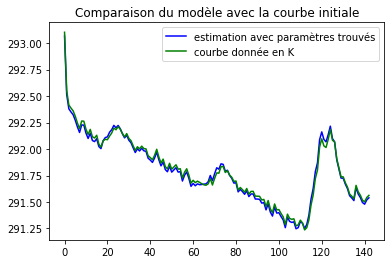

In [132]:
a, b, l = popt[0], popt[1], popt[2]
Precision_X = np.array([[X1[i], X2[i], X3[i]] for i in range(len(X1))])
Precision_Y = np.array([func(Precision_X[i], a, b, l) for i in range(len(Precision_X))])
plt.plot(Precision_Y, c='b', label='estimation avec paramètres trouvés')
plt.plot(Y1[:-1] +273.15, c='g', label='courbe donnée en K')
plt.legend(loc='upper right')
plt.title("Comparaison du modèle avec la courbe initiale")
plt.show()

On a cependant que deux équations qui relient nos trois constantes (en effet $\beta = 1 - \alpha$) ce qui ne permet pas d'aboutir sur l'identification de nos constantes, d'où le besoin de la résolution numérique de l'équation différentielle avant de pouvoir effectuer une regréssion LM sur nos résidus non linéaires. 